<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-small.png"/></a>
<a href="https://shebanq.ancient-data.org" target="_blank"><img align="left"src="images/shebanq_logo_small.png"/></a>
<a href="http://dx.doi.org/10.17026/dans-z6y-skyh" target="_blank"><img align="left"src="images/DANS-logo_small.png"/></a>
<a href="https://www.dbg.de/index.php?L=1" target="_blank"><img align="right" src="images/DBG-small.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-small.png"/></a>

# Topic analysis

Joint work of Mathias Coeckelbergs and Dirk Roorda.

Mathias is experimenting with topic detection experiments using Mallet.
Here is a way to visualize topics.

We are still in a preliminary stage (2016-04-06).

Dirk prepares the text in various froms. Mathias runs Mallet and produces sets of topics.
Then Dirk depicts those topics in graphs.

Currently we are still experimenting with topic sets of various fixed sizes $n$, for $n$ in $30,40,50,60,70,80,90$.

# Start up

In [1]:
import os, sys, collections, re
import networkx as nx
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Data source

In [2]:
source='etcbc'
version='4b'

# ETCBC database

In [3]:
from laf.fabric import LafFabric
from etcbc.preprocess import prepare

fabric = LafFabric()
API=fabric.load(source+version, 'lexicon', 'topics', {
    "xmlids": {"node": False, "edge": False},
    "features": ('''
        otype
        lex
        sp gloss
        g_entry_heb
    ''',''),
    "prepare": prepare,
    "primary": False,
})
exec(fabric.localnames.format(var='fabric'))

  0.00s This is LAF-Fabric 4.6.0
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: https://shebanq.ancient-data.org/static/docs/featuredoc/texts/welcome.html

  0.00s LOADING API: please wait ... 
  0.00s USING main  DATA COMPILED AT: 2015-11-02T15-08-56
  0.00s USING annox DATA COMPILED AT: 2016-01-27T19-01-17
  2.70s LOGFILE=/Users/dirk/laf/laf-fabric-output/etcbc4b/topics/__log__topics.txt
  2.70s INFO: LOADING PREPARED data: please wait ... 
  2.70s prep prep: G.node_sort
  2.81s prep prep: G.node_sort_inv
  3.30s prep prep: L.node_up
  7.39s prep prep: L.node_down
    15s prep prep: V.verses
    15s prep prep: V.books_la
    15s ETCBC reference: http://laf-fabric.readthedocs.org/en/latest/texts/ETCBC-reference.html
    16s INFO: LOADED PREPARED data
    16s INFO: DATA LOADED FROM SOURCE etcbc4b AND ANNOX lexicon FOR TASK topics AT 2016-04-12T09-09-01


# Hebrew text

In the first experiment we worked with a plain text in phonemic representation. No attempt to deal with morphology was made. The various topic sets varied wildly, with only a few topics showing up in the intersections of topic sets.
This indicates that the topic assignment is not very stable.

In the second experiment
we prepare a more suitable version of the Hebrew text for topic detection and post processing.
This is what we do: instead of taking the plain full text, we produce a sequence of lexeme identifiers.
At the same time we generate a mapping between lexeme identifiers and fully vocalized lexemes and additional properties such as gloss and part-of-speech.
When Mallet has done its work with the lexeme identifiers, we process the results and convert the identifiers back to real lexemes or glosses.

## Lexeme identifiers
The ETCBC database identifies lexemes by their transcription in ETCBC format, with added tokens for disambiguation.
However, we want lexeme identifiers consisting of letters only. And because we maintain a mapping from identifiers to
vocalized Hebrew representations and glosses, we are free to choose any abstract representation.

We order the lexemes by frequency, identify a lexeme by its rank number in this ordering (most frequent lexemes get the lowest numbers) and represent this number in a 26-ary number representation, where we choose the lowercase ASCII letters as digits.

In [71]:
LEXTABLE = 'lexemes.txt'

In [72]:
msg('Fetching lexeme info')
lexeme_info = {}
lexeme_freq = collections.Counter()

for w in F.otype.s('word'):
    lex = F.lex.v(w)
    gl = F.gloss.v(w)
    vl = F.g_entry_heb.v(w)
    psp = F.sp.v(w)
    if lex not in lexeme_info:
        lexeme_info[lex] = (vl, psp, gl)
    lexeme_freq[lex] += 1
msg('Done: {} lexemes'.format(len(lexeme_info)))

 5h 35m 43s Fetching lexeme info
 5h 35m 46s Done: 8777 lexemes


### Generating lexeme identifiers

In [73]:
def to_ascii(i):
    if i < 26: return chr(ord('a') + i)
    else:
        return to_ascii(int(i / 26)) + chr(ord('a') + i % 26)
msg('Compiling lexeme table')
lexeme_sorted = sorted(lexeme_freq, key=lambda x: (-lexeme_freq[x], x))
lexeme2id = {}
lexeme_index = {}
for (i, lex) in enumerate(lexeme_sorted):
    lid = to_ascii(i)
    (vl, psp, gl) = lexeme_info[lex]
    lexeme_index[lid] = (lex, vl, psp, gl, lexeme_freq[lex])
    lexeme2id[lex] = lid
with open(LEXTABLE, 'w') as fh:
    fmt = '{}\t'*5+'{}\n'
    fh.write(fmt.format('lexid', 'lexeme', 'vocalized', 'p_o_s', 'gloss', 'freq'))
    for lid in sorted(lexeme_index, key=lambda x: -lexeme_index[x][4]):
        fh.write(fmt.format(lid, *lexeme_index[lid]))
msg('Done')

 5h 35m 51s Compiling lexeme table
 5h 35m 51s Done


# Generating a lexeme text

Here we generate the text representation to be fed to Mallet.

In [74]:
msg('Serializing the text')
lexeme_seq = (lexeme2id[F.lex.v(w)] for w in F.otype.s('word'))

with open('ltext_{}{}.txt'.format(source, version), 'w') as fh:
    fh.write(''.join('{}{}'.format(l, '\n' if (i+1) % 30 == 0 else ' ') for (i,l) in enumerate(lexeme_seq)))
msg('Done')

 5h 35m 56s Serializing the text
 5h 35m 58s Done


# Topic sources

In [75]:
topic_files_1 = glob('{}_*_keys.txt'.format(source))       # experiment 1
topic_files_2 = glob('lexemes_keys_*.txt'.format(source))  # experiment 2
topic_files = topic_files_2
topic_files

['lexemes_keys_30.txt',
 'lexemes_keys_40.txt',
 'lexemes_keys_50.txt',
 'lexemes_keys_60.txt',
 'lexemes_keys_70.txt',
 'lexemes_keys_80.txt',
 'lexemes_keys_90.txt']

# Read the topic files

Every topic is a number. We associate a tuple to each topic, namely

    (nn,tp)
    
where `nn` is the number of topics in the file (indicated in the file name) and
`tp` is the topic number within the file.

We collect the topics in a dictionary containing for each topic the set of its words.

We also translate the topic words into full Hebrew and into glosses.
To that end, we read the file *lexemes.txt*.

In [76]:
mask_1 = re.compile('{}_([0-9]+)_keys.txt'.format(source))       # experiment 1
mask_2 = re.compile('lexemes_keys_([0-9]+).txt'.format(source))  # experiment 2
mask = mask_2
topic = {}
topicsets = set()

lex_data = {}

def get_lexemes():
    with open(LEXTABLE) as fh:
        for line in fh:
            (lexid, lexeme, vocalized, p_o_s, gloss, freq) = line.rstrip('\n').split('\t')
            lex_data[lexid] = (lexeme, vocalized, p_o_s, gloss, freq)

def get_topics(n, tfile):
    df = open('topic_data_{}.txt'.format(n), 'w')
    with open(tfile) as fh:
        for line in fh:
            (tp, nm, word_list) = line.rstrip().split('\t')
            words = word_list.split()
            topic[(n, int(tp))] = words
            df.write('{:>4} {:<20} '.format('Tpc', tp))
            for (i, w) in enumerate(words):
                (pos, glo) = lex_data[w][2:4] 
                df.write('{:<4} {:<20} '.format(pos, glo))
                if (i+1) % 5 == 0: df.write('\n'+' '*26)
            df.write('\n')
    df.close()

get_lexemes()

for topic_file in topic_files:
    ntopics = int(mask.match(topic_file).group(1))
    topicsets.add(ntopics)
    get_topics(ntopics, topic_file)

print('{} topics found in sets {}'.format(len(topic), ', '.join(sorted(str(x) for x in topicsets))))

420 topics found in sets 30, 40, 50, 60, 70, 80, 90


Later on we need topic info in order to interpret certain visualizations. `topic_info` does that.
It lists all the words that belong to a topic, and represents them as etcbc-lexeme, vocalized hebrew, gloss, paet of speech, or frequency.

In [77]:
kinds = dict(
    elex=0,
    hvoc=1,
    posp=2,
    glss=3,
    freq=4,
)

def topic_info(t, kind):
    if (t) not in topic: return 'No topic ({},{})'.format(*t)
    words = topic[t]
    if kind not in kinds: return 'No such kind {}'.format(kind)
    return ' | '.join(str(lex_data[w][kinds[kind]]) for w in words)

# Word index

We make an inverse mapping as well: a dictionary that for each word gives the set of topics that contain that word.

In [78]:
word_topic = collections.defaultdict(set)

def word2topic():
    for tp in topic:
        for w in topic[tp]: word_topic[w].add(tp)
    print('{} words found'.format(len(word_topic)))

word2topic()

2921 words found


# Edges

Now we can compute edges. We make a weighted undirected edge between each pair of topics that share a word.
The weight is the number of edges connecting two topics.
We do not add reflexive edges, i.e. edges from a topic to itself.

The method is: walk through all the words, pick the ones that belong to multiple topics, and add the edge weight for
every pair among those multiple topics.

In [79]:
edges = collections.Counter()

def get_edges():
    for w in word_topic:
        tps = sorted(word_topic[w])
        ntps = len(tps)
        if ntps > 1:
            for i in range(ntps - 1):
                for j in range(i+1, ntps):
                    edges[(tps[i], tps[j])] += 1
    print('{} edges found'.format(len(edges)))

get_edges()

13584 edges found


# Writing

We write the graph in ncol format, so that it can be loaded into other tools.
This is not needed for the rest of this notebook.

In [80]:
NCOL_FILE = 'edges.ncol'
def write_ncol():
    with open(NCOL_FILE, 'w') as fh:
        for (e,w) in edges.items(): fh.write('{}-{}\t{}-{}\t{}\n'.format(*e[0], *e[1],w))

write_ncol()

## Distribution of weights
There are edges between topics within the same set, and edges between topics of different sets.

### All edges
Here is the distribution of the weights for all edges.

0, 11728, 1613, 213, 28, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


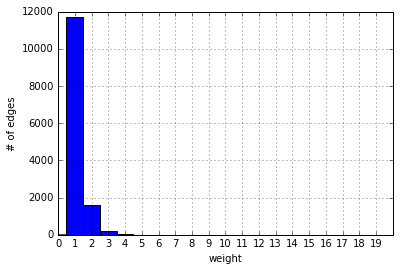

In [81]:
nbins = 20
x = sorted(edges.values())
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

### Intra-set edges

Here is the distribution of weights on edges that are between topics in the same set.

0, 652, 13, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


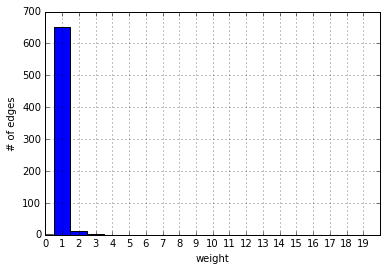

In [82]:
x = sorted(edges[(x,y)] for (x,y) in edges if x[0] == y[0])
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

We see that topics consist of fairly diverse words, they never happen to share more than one word.

### Inter-set edges

Here is the distribution of weights on edges that are between topics in different sets.

0, 11076, 1600, 212, 28, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


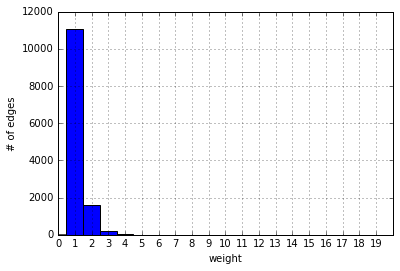

In [83]:
x = sorted(edges[(x,y)] for (x,y) in edges if x[0] != y[0])
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

# Graphs

We create graphs directly from the nodes in dictionary `topic` and the edges in Counter `edges`.

The parameter `ns` is a set of numbers, indicating the topic sets that we want to include in the graph.

In [84]:
def create_graph(ns, mode='c'): # ns is a set of numbers
    g = nx.Graph()
    g.add_nodes_from(x for x in topic if x[0] in ns)
    if mode == 's':
        neighbours = collections.defaultdict(set)
        sortedns = sorted(ns)
        for (x, y) in zip(sortedns[0:-1], sortedns[1:]): neighbours[x].add(y)
        for (x, y) in zip(sortedns[1:], sortedns[0:-1]): neighbours[x].add(y)
        g.add_weighted_edges_from(
            (x,y,w) for ((x,y),w) in edges.items() if x[0] in ns and y[0] in ns and y[0] in neighbours[x[0]]
        )
    else:
        g.add_weighted_edges_from((x,y,w) for ((x,y),w) in edges.items() if x[0] in ns and y[0] in ns)
    return g

# Drawing

We draw multiple topic sets in one graph, but give topics distinct colors, corresponding to the sets they come from.

The edges get a width and color depending on their weight. Edges of weight 1 are barely visible, only heavier edges will contribute.There are several ways to draw the graphs of combined topic sets:

1. **i=individual** compute layouts per topic set and then superpose the layouts
1. **c=combined** compute one layout for the combined graph
1. **s=separate** position the nodes of the topic sets in different columns

The parameter `mode` (combined) regulates this.

We use the separate layout to view how much correspondence there is between topics in the distinct sets.
We order the topic sets according to their size, and we consider only edges between neighbouring sets.
Moreover, we suppress light edges, so that the focus is on the strong relationships between the topics.

First some style paramaters.

We color the nodes depending on the set they come from. We use the RGB and CMYK standard colors.

We make the size dependent on the mode: mode **s** needs a bigger vertical dimension.

Also in mode **s**, it is convenient to suppress the visibility of light edges. We do this by subtracting a value, EDGE_THRESHOLD, from the width of all edges. Negative widths will become zero.

In [85]:
NCOLORS = {
    30: 'r',
    40: 'g',
    50: 'b',
    60: 'c',
    70: 'm',
    80: 'y',
    90: 'k',
}
NSIZE = dict(
    i=200,
    c=200,
    s=50,
)
XSIZE = dict(
    i=10,
    c=10,
    s=20,
)
YSIZE = dict(
    i=10,
    c=10,
    s=20,
)
EDGE_THRESHOLD = dict(
    i=0,
    c=0,
    s=2,
)

Here is the draw function

In [86]:
def draw_graph(ns, mode='c'): # ns is a set of numbers
    xsize, ysize = (p[mode] for p in (XSIZE, YSIZE))
    if mode not in 'cis':
        print('Unknown mode "{}".format(mode)')
        return

    plt.figure(figsize=(xsize, ysize))
    if mode == 's':
        plt.xlim(-1, xsize+1)
        plt.ylim(-1, ysize+1)
    g = create_graph(ns, mode=mode)
    extra = {}
    if mode == 'c':
        pos = nx.spring_layout(
            g,
            k=1,
        )
    elif mode == 'i':
        gs = {}
        for n in ns: gs[n] = create_graph({n})
        pos = {}
        for n in ns: pos.update(nx.spring_layout(
            gs[n],
            k=None,
        ))
    elif mode == 's':
        pos = {}
        srtns = sorted(ns)
        lns = len(srtns)
        xpos = {}
        if lns == 1: xpos[srtns[0]] = xsize / 2
        else:
            for j in range(lns): xpos[srtns[j]] = xsize * j / (lns - 1)
        for n in ns:
            srtnds = sorted(nd for nd in g.nodes() if nd[0] == n)
            lnds = len(srtnds)
            if lnds == 1: pos[srtnds[0]] = (xpos[n], ysize / 2)
            else:
                for j in range(lnds): pos[srtnds[j]] = (xpos[n], ysize * j / (lnds - 1))
        nlabels = dict((x, '{}{}'.format(' '*6,x[1])) for x in g.nodes())
        extra.update(labels=nlabels)

    nx.draw(g, pos,
        node_size=NSIZE[mode],
        width=[max((-EDGE_THRESHOLD[mode] + g.get_edge_data(*x)['weight'], 0)) for x in g.edges()],
        node_color=[NCOLORS[n] for (n,t) in g.nodes()],
        edge_color=[g.get_edge_data(*x)['weight'] for x in g.edges()],
        edge_cmap=plt.cm.Greys,
        edge_vmin=-5,
        edge_vmax=20,
        alpha=1,
        linewidths=0,
        **extra,
    )
    print('{} x {}'.format(plt.xlim(), plt.ylim()))

## Draw one topic set at a time

(-1.5, 1.5) x (-1.5, 1.5)


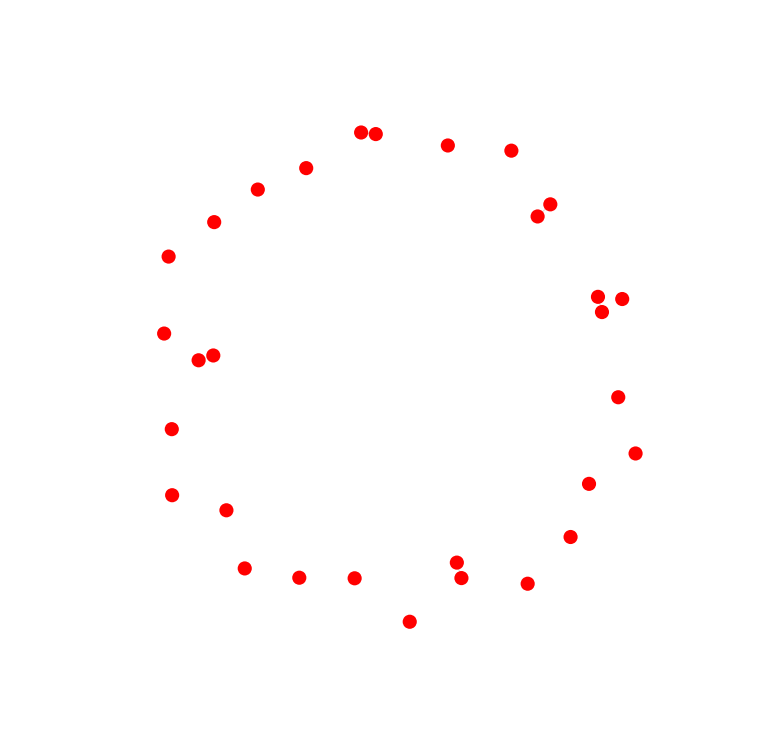

In [87]:
draw_graph({30}, mode='i')

(-1.5, 1.0) x (-1.0, 1.5)


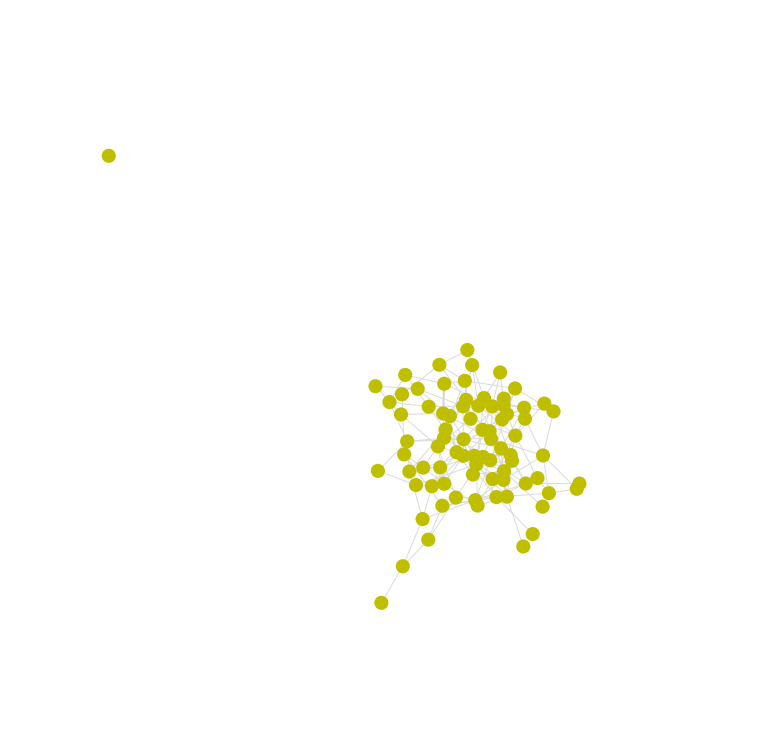

In [88]:
draw_graph({80}, mode='i')

## Draw multiple topic sets at a time

(-1.5, 1.5) x (-1.5, 1.5)


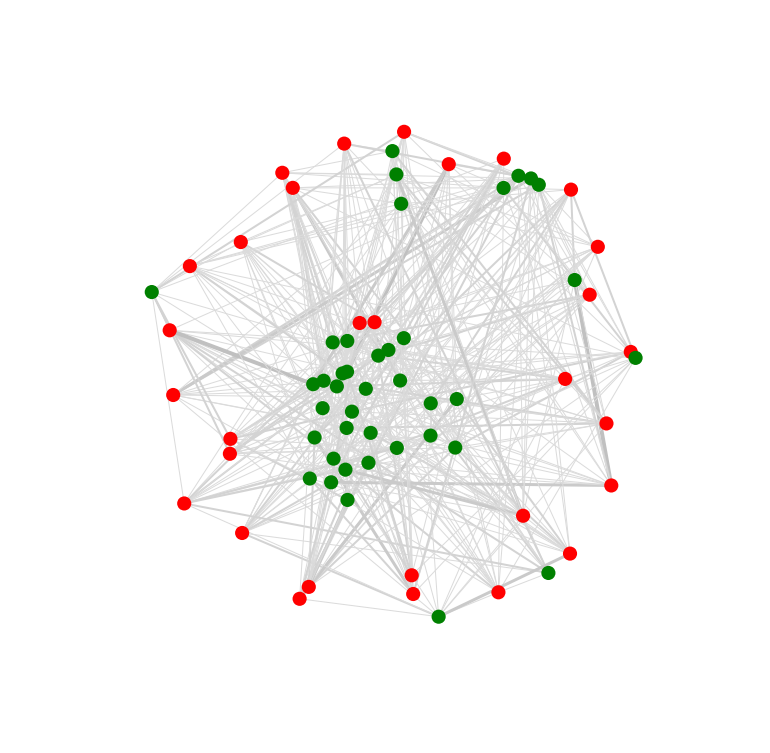

In [89]:
draw_graph({30, 40}, mode='i')

(-2.5, 1.5) x (-1.0, 1.5)


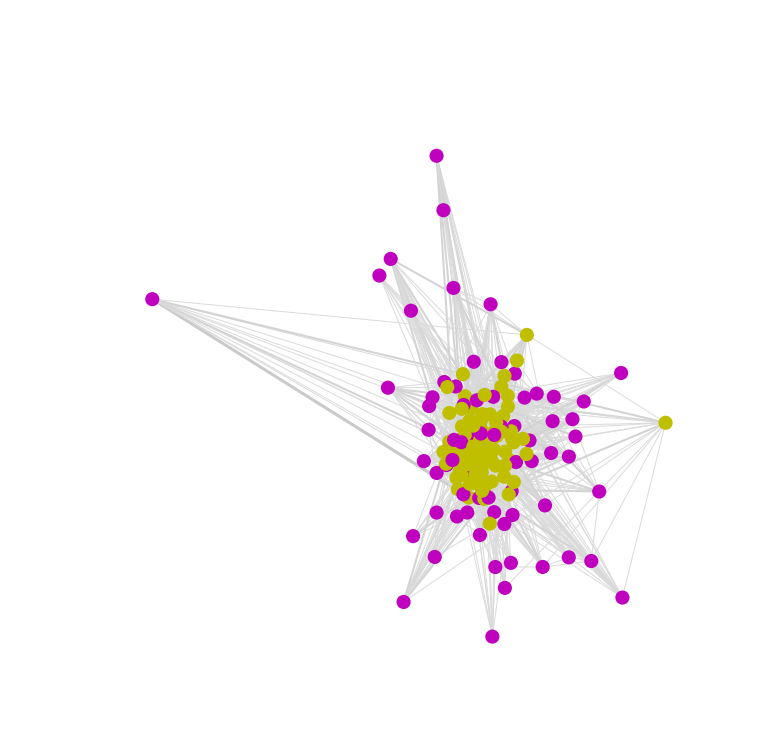

In [90]:
draw_graph({70, 80}, mode='i')

(-2.5, 1.5) x (-5.0, 2.0)


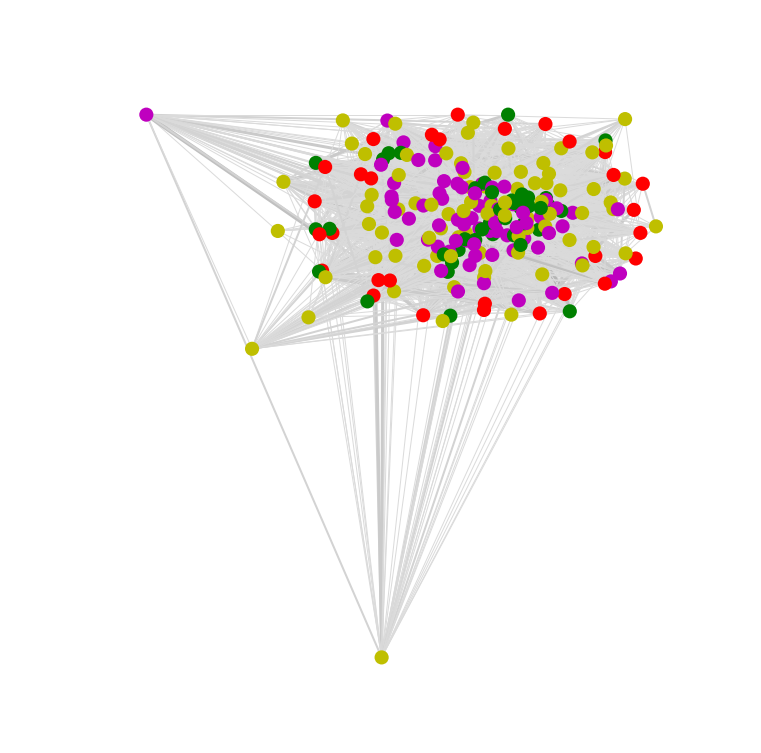

In [91]:
draw_graph({30,40,70,80}, mode='i')

# Draw multiple topic sets at once

In the previous examples, we did the graph layout per topic set, and then combined the layouts.
Now we do a layout at once.

(-1.5, 1.5) x (-1.5, 1.5)


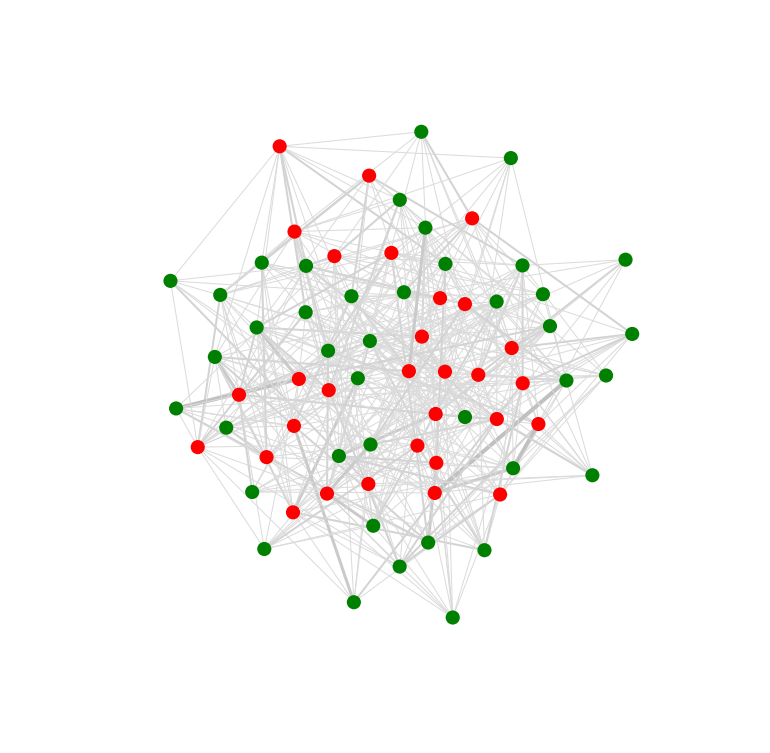

In [92]:
draw_graph({30, 40}, mode='c')

(-1.5, 1.5) x (-1.5, 1.5)


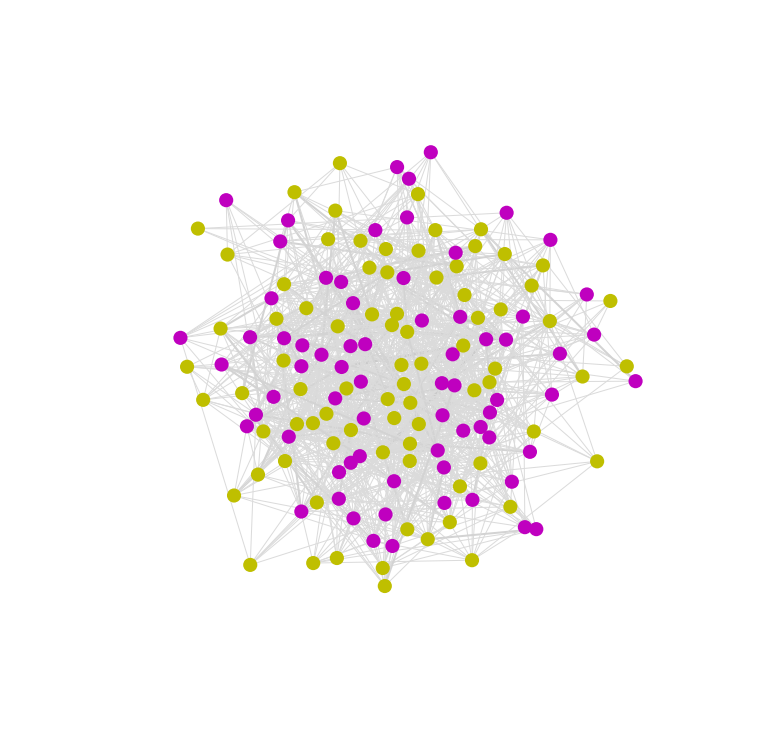

In [93]:
draw_graph({70, 80}, mode='c')

(-1.5, 1.5) x (-1.5, 1.5)


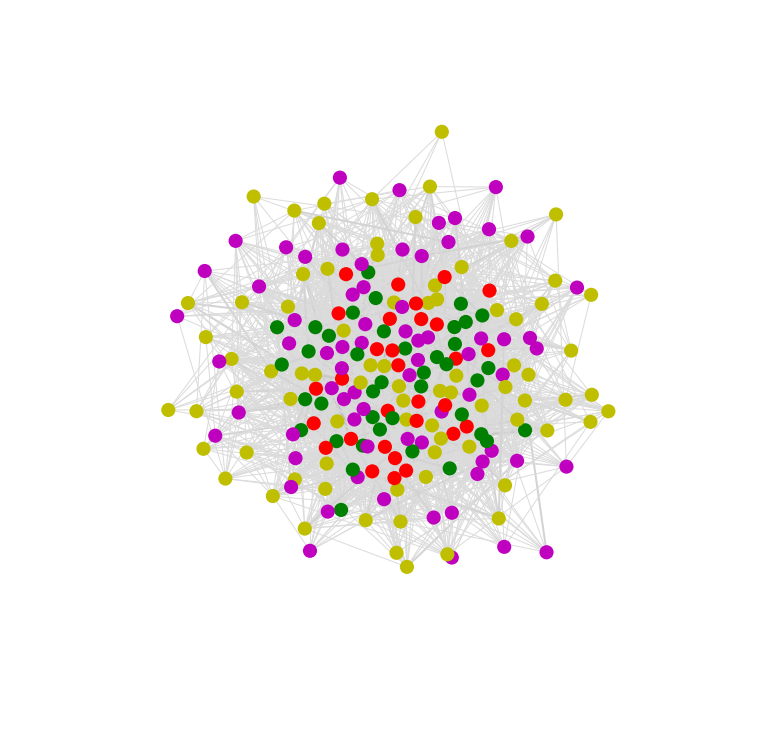

In [94]:
draw_graph({30,40,70,80}, mode='c')

## Draw all topic sets in separated mode

(-1.0, 21.0) x (-1.0, 21.0)


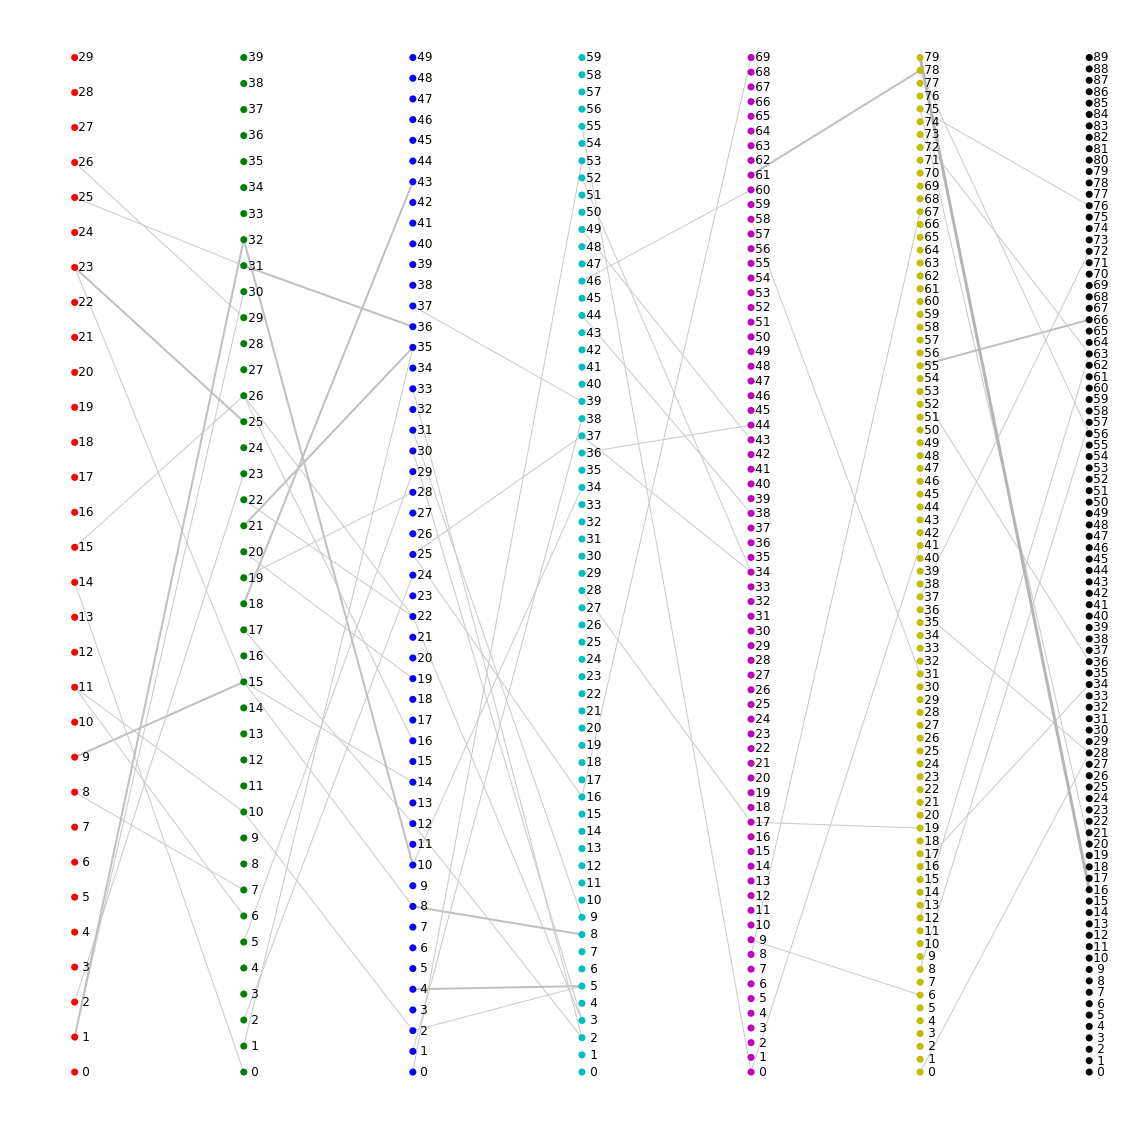

In [95]:
draw_graph(topicsets, mode='s')

Let us zoom in on the differences between the 80-set and the 90-set.
One would expect that a fair amount of the topics in one set correspond to topics in the other set.

(-1.0, 21.0) x (-1.0, 21.0)


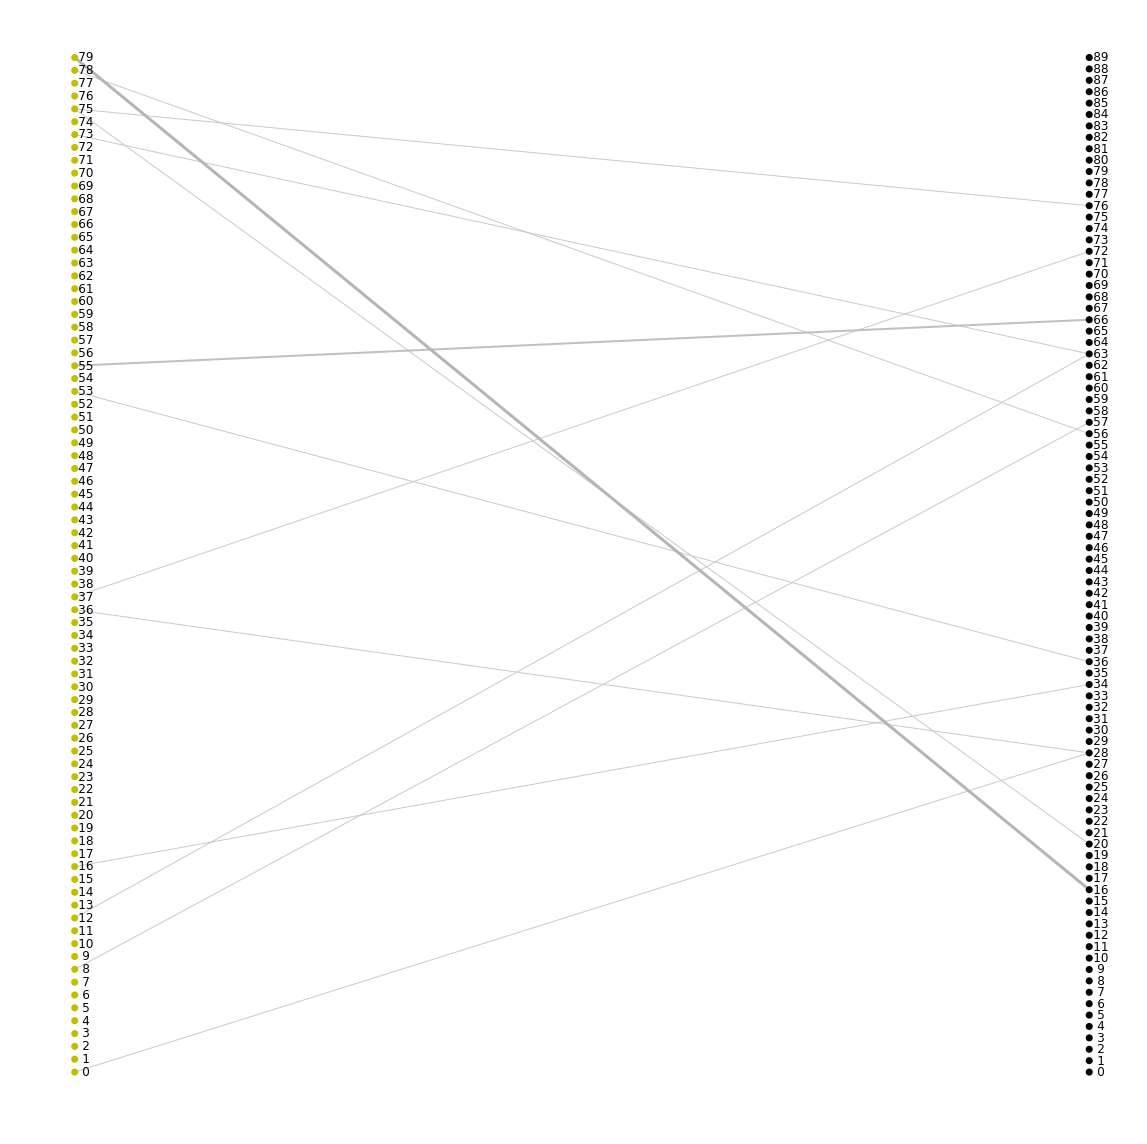

In [96]:
draw_graph({80,90}, mode='s')

There is a fairly strong link between 80~79 and 90~16, and also between 80~55 and 90~66. Here are those topics.

In [70]:
for t in (
    (80, 79),
    (90, 16),
    (80, 55),
    (90, 66),
):
    print('Topic {}~{} = {}\n'.format(*t, topic_info(t, 'glss')))

Topic 80~79 = couch | wash | the Lord | wait for | sing | ephod | open place | break | blow | harvest | generations | totter | breaking | draw off | fear | Isaiah | be high | dew | Gideon | scatter

Topic 90~16 = divide | labour | couch | Passover | virgin | cling, cleave to | hips | harvest | give attention | curtain | gird | rare | anger | happiness | scatter | break | draw off | back(wards) | mourn | love

Topic 80~55 = consecrate | curtain | where | next day | quiver | rebel | people | fortification | moon | adversary | be united | Tarshish | fasting | be superior | present | mention | Meshullam | explore | way | Ben-Hadad

Topic 90~66 = Zadok | next day | Zebulun | Joash | rebel | be terrified | consecrate | be unfaithful | warn, to witness | fortification | future | Persia | hire | turn | Phinehas | Azariah | uncleanness | try | uncircumcised | Darius



Topic detection is stable if there are many strong links between topics in different sets.

For example, if there is a topic in one set that can be labeled as *country*, 
we expect that the other sets also have such a topic, and that the words that support it in one set
have a large intersection with the words that support it in an other set.

However, in these visualizations, we see only a few topics that are related, and not very strongly.